In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import Lasso
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import time
import os
import sklearn

In [2]:
os.listdir('./data/')

['application_test.csv',
 'application_train.csv',
 'bureau.csv',
 'bureau_balance.csv',
 'credit_card_balance.csv',
 'HomeCredit_columns_description.csv',
 'installments_payments.csv',
 'POS_CASH_balance.csv',
 'previous_application.csv',
 'sample_submission.csv']

In [3]:
os.listdir('./working/')

['bu_features.csv',
 'credit_card_by_current.csv',
 'credit_card_by_previous.csv',
 'installment_feature.csv',
 'POS_CASH_by_current_feature.csv',
 'POS_CASH_by_previous.csv',
 'previous_application_feature.csv',
 'submission.csv']

In [59]:
train = pd.read_csv('./data/application_train.csv')
test = pd.read_csv('./data/application_test.csv')

In [4]:
variables = train.dtypes
category = variables[variables==variables['NAME_CONTRACT_TYPE']].index.to_list()
numerical = variables[variables!=variables['NAME_CONTRACT_TYPE']].index.to_list()
dummy = pd.get_dummies(train[category])
train = pd.concat([train[numerical],dummy],axis=1)

In [7]:
corr_ = train.corr()['TARGET']

In [12]:
id_range = pd.concat([train['SK_ID_CURR'],test['SK_ID_CURR']],axis=0)
id_range.shape

(356255,)

### 1 Feature engineering

### 1.1 bureau data

bureau balance status -> turn into dummy variables and exponentially weighted by month

In [104]:
bu_balance = pd.read_csv('./data/bureau_balance.csv')
bu_balance['months_exp'] = np.exp(bu_balance['MONTHS_BALANCE'])
merged = pd.concat([bu_balance,pd.get_dummies(bu_balance['STATUS'])],axis=1)
status = ['0', '1', '2', '3', '4', '5', 'C', 'X']
weighted_status = ['STATUS_' + _ for _ in status]
for s in status:
    merged[s] = merged[s] * merged['months_exp']

In [105]:
weighted_bu_status = merged.groupby(['SK_ID_BUREAU'])[status].sum().reset_index()
weighted_bu_status.rename(columns=dict(zip(status,weighted_status)),inplace=True)
# weighted_bu_status.to_csv('./working/weighted_bureau_balance.csv')
weighted_bu_status

,SK_ID_BUREAU,STATUS_0,STATUS_1,STATUS_2,STATUS_3,STATUS_4,STATUS_5,STATUS_C,STATUS_X
0,5001709,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,1.581977,7.077296e-38
1,5001710,1.724699e-21,0.000000e+00,0.0,0.0,0.0,0.000000,1.581977,5.298771e-22
2,5001711,5.530018e-01,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000,1.000000e+00
3,5001712,1.952226e-04,0.000000e+00,0.0,0.0,0.0,0.000000,1.581781,0.000000e+00
4,5001713,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000,1.581977e+00
...,...,...,...,...,...,...,...,...,...
817390,6842884,4.965422e-17,0.000000e+00,0.0,0.0,0.0,0.000000,1.581977,3.260697e-09
817391,6842885,9.719941e-06,0.000000e+00,0.0,0.0,0.0,1.581967,0.000000,0.000000e+00
817392,6842886,2.196303e-11,0.000000e+00,0.0,0.0,0.0,0.000000,1.581977,0.000000e+00
817393,6842887,5.432420e-14,0.000000e+00,0.0,0.0,0.0,0.000000,1.581977,0.000000e+00


NA percentage

In [125]:
bu = pd.read_csv('./data/bureau.csv')
bu = pd.merge(bu,weighted_bu_status,on='SK_ID_BUREAU',how='left')
bu['STATUS_5'].isnull().sum()/bu.shape[0]

0.5488572780215657

In [116]:
bu.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

CREDIT_ACTIVE       4
CREDIT_CURRENCY     4
CREDIT_TYPE        15
dtype: int64

In [121]:
variables = bu.dtypes
category = variables[variables==np.dtype('O')].index.to_list()
category

['CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE']

In [126]:
variables = bu.dtypes
category = variables[variables==np.dtype('O')].index.to_list()
category.remove('CREDIT_TYPE')
numerical = variables[variables!=np.dtype('O')].index.to_list()
dummy = pd.get_dummies(bu[category])
bu = pd.concat([bu[numerical],dummy],axis=1)
bu.fillna(bu.median(),inplace=True)
bu = bu[bu['DAYS_CREDIT']>-1000]
bu.groupby('SK_ID_CURR')[bu.columns[2:].to_list()].mean().reset_index().to_csv('./working/bu_features.csv')

## 1.2 credit card balance

In [57]:
credit_card[['SK_ID_PREV','SK_ID_CURR']].drop_duplicates().shape

(104307, 2)

In [38]:
credit_card['SK_ID_PREV'].unique().shape

(104307,)

In [39]:
credit_card['SK_ID_CURR'].unique().shape

(103558,)

In [45]:
na_per = credit_card.isnull().sum()/credit_card.shape[0]
na_per[na_per!=0]

AMT_DRAWINGS_ATM_CURRENT      0.195249
AMT_DRAWINGS_OTHER_CURRENT    0.195249
AMT_DRAWINGS_POS_CURRENT      0.195249
AMT_INST_MIN_REGULARITY       0.079482
AMT_PAYMENT_CURRENT           0.199981
CNT_DRAWINGS_ATM_CURRENT      0.195249
CNT_DRAWINGS_OTHER_CURRENT    0.195249
CNT_DRAWINGS_POS_CURRENT      0.195249
CNT_INSTALMENT_MATURE_CUM     0.079482
dtype: float64

In [154]:
credit_card = pd.read_csv('./data/credit_card_balance.csv')
credit_card.sort_values(['SK_ID_PREV','MONTHS_BALANCE'],ascending=[1,0],inplace=True)
status = credit_card.groupby(['SK_ID_PREV']).head(1).reset_index()[['SK_ID_PREV','NAME_CONTRACT_STATUS','MONTHS_BALANCE']]
variables = credit_card.dtypes
numerical = variables[variables!=np.dtype('O')].index.to_list()[3:]
credit_card['months_exp'] = np.exp(credit_card['MONTHS_BALANCE'])
def weight(df):
    return df['months_exp']/df['months_exp'].sum()
weight = credit_card.groupby('SK_ID_PREV').apply(weight).reset_index()
weight.sort_values(by='level_1')
weight.set_index('level_1',inplace=True)
credit_card['weight'] = weight['months_exp']
for s in numerical:
    credit_card[s] = credit_card[s] * credit_card['weight']
by_previous = credit_card.groupby(['SK_ID_PREV','SK_ID_CURR'])[numerical].sum().reset_index()
by_previous = pd.merge(by_previous,status,on='SK_ID_PREV',how='left')
variables = by_previous.dtypes
category = variables[variables==np.dtype('O')].index.to_list()
numerical = variables[variables!=np.dtype('O')].index.to_list()
by_previous = pd.concat([by_previous[numerical],pd.get_dummies(by_previous[category])],axis=1)
by_previous.to_csv('./working/credit_card_by_previous.csv',index=False)

In [155]:
status['NAME_CONTRACT_STATUS'].value_counts()

Active       90952
Completed    13295
Signed          38
Demand          22
Name: NAME_CONTRACT_STATUS, dtype: int64

In [36]:
by_current = pd.read_csv('./working/credit_card_by_previous.csv')
by_current.columns

Index(['SK_ID_PREV', 'SK_ID_CURR', 'AMT_BALANCE', 'AMT_CREDIT_LIMIT_ACTUAL',
       'AMT_DRAWINGS_ATM_CURRENT', 'AMT_DRAWINGS_CURRENT',
       'AMT_DRAWINGS_OTHER_CURRENT', 'AMT_DRAWINGS_POS_CURRENT',
       'AMT_INST_MIN_REGULARITY', 'AMT_PAYMENT_CURRENT',
       'AMT_PAYMENT_TOTAL_CURRENT', 'AMT_RECEIVABLE_PRINCIPAL',
       'AMT_RECIVABLE', 'AMT_TOTAL_RECEIVABLE', 'CNT_DRAWINGS_ATM_CURRENT',
       'CNT_DRAWINGS_CURRENT', 'CNT_DRAWINGS_OTHER_CURRENT',
       'CNT_DRAWINGS_POS_CURRENT', 'CNT_INSTALMENT_MATURE_CUM', 'SK_DPD',
       'SK_DPD_DEF', 'MONTHS_BALANCE', 'NAME_CONTRACT_STATUS_Active',
       'NAME_CONTRACT_STATUS_Completed', 'NAME_CONTRACT_STATUS_Demand',
       'NAME_CONTRACT_STATUS_Signed'],
      dtype='object')

In [56]:
by_current = pd.read_csv('./working/credit_card_by_previous.csv')
active = by_current.loc[(by_current['MONTHS_BALANCE']>-3)&(by_current['NAME_CONTRACT_STATUS_Active']==1)]
numerical = active.columns[2:-4]
s = active.columns[-4:]
state = by_current.groupby('SK_ID_CURR')[s].sum().reset_index()
grouped = active.groupby('SK_ID_CURR')[numerical].sum().reset_index()
grouped.drop(columns='MONTHS_BALANCE',inplace=True)
grouped = pd.merge(grouped,state,on='SK_ID_CURR',how='right')
grouped.fillna(0)
grouped.to_csv('./working/credit_card_by_current.csv',index=False)

In [58]:
grouped

,SK_ID_CURR,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,...,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,SK_DPD,SK_DPD_DEF,NAME_CONTRACT_STATUS_Active,NAME_CONTRACT_STATUS_Completed,NAME_CONTRACT_STATUS_Demand,NAME_CONTRACT_STATUS_Signed
0,100006,0.000000e+00,270000.000000,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,...,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1,0,0,0
1,100011,3.369941e-14,90000.203430,2.252036e-27,2.252036e-27,0.0,0.000000e+00,1.622558e-14,563.355000,5.998986e-14,...,5.004523e-32,0.0,0.000000e+00,33.000000,0.000000e+00,0.000000e+00,1,0,0,0
2,100013,3.099763e-24,45000.000031,2.828027e-26,2.828027e-26,0.0,0.000000e+00,1.561152e-24,274.320000,5.446469e-24,...,1.005638e-30,0.0,0.000000e+00,22.000000,1.856843e-30,1.856843e-30,1,0,0,0
3,100021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0
4,100023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103553,456244,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0
103554,456246,7.455434e+02,135000.000000,0.000000e+00,1.416135e+03,0.0,1.416135e+03,4.159437e+02,2551.706701,2.409573e+03,...,7.423801e-01,0.0,7.423801e-01,6.420708,0.000000e+00,0.000000e+00,1,0,0,0
103555,456247,1.610209e-24,0.001009,1.251365e-27,2.107361e-27,0.0,8.559957e-28,4.373061e-24,520.605000,3.441763e-27,...,3.915789e-30,0.0,2.049283e-30,32.000000,1.693430e-33,2.089696e-37,1,0,0,0
103556,456248,0.000000e+00,900000.000000,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,...,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1,0,0,0


In [57]:
grouped.iloc[:,1:].describe()

,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,...,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,SK_DPD,SK_DPD_DEF,NAME_CONTRACT_STATUS_Active,NAME_CONTRACT_STATUS_Completed,NAME_CONTRACT_STATUS_Demand,NAME_CONTRACT_STATUS_Signed
count,8.437600e+04,8.437600e+04,8.437600e+04,8.437600e+04,84376.000000,8.437600e+04,84376.000000,8.437600e+04,8.437600e+04,8.437600e+04,...,8.437600e+04,84376.000000,84376.000000,84376.000000,84376.000000,84376.000000,103558.000000,103558.000000,103558.000000,103558.000000
mean,9.031773e+04,1.874858e+05,5.020901e+03,1.059081e+04,113.204222,5.422589e+03,4517.712998,1.084971e+04,9.796957e+03,8.695612e+04,...,1.592507e+00,0.001886,1.327384,16.213793,6.429378,0.020551,0.878271,0.128382,0.000212,0.000367
std,1.545012e+05,2.037022e+05,2.067452e+04,3.492259e+04,3535.309699,2.582828e+04,7661.172400,3.296303e+04,3.238143e+04,1.491395e+05,...,4.806614e+00,0.040564,4.613517,21.689947,96.692362,0.968829,0.327711,0.337877,0.014574,0.019152
min,-5.817718e-12,0.000000e+00,-2.417989e-05,-4.650411e-25,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,-5.817720e-12,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000e+00,4.500000e+04,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,1.265183e-01,1.349989e+05,1.002734e-20,8.307849e-03,0.000000,0.000000e+00,0.003607,8.771625e+02,1.124173e+02,1.600955e-02,...,1.025081e-07,0.000000,0.000000,7.419134,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,1.377855e+05,2.657236e+05,4.414578e+02,5.518565e+03,0.000000,4.873243e+02,6821.655756,1.158064e+04,9.641601e+03,1.319991e+05,...,9.519341e-01,0.000000,0.137815,22.418023,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,1.156324e+06,1.350000e+06,6.968538e+05,1.739090e+06,425998.690146,1.739090e+06,60250.666605,1.854925e+06,1.854481e+06,1.129872e+06,...,1.185189e+02,2.634518,118.518931,119.418023,2724.018035,178.820055,2.000000,3.000000,1.000000,1.000000


## 1.3 Pos cash balance

In [15]:
pos_cash = pd.read_csv('./data/POS_CASH_balance.csv')
pos_cash.shape

(10001358, 8)

In [46]:
id_range.shape

(356255,)

In [48]:
pos_cash['SK_ID_CURR'].unique().shape

(337252,)

In [16]:
pos_cash = pd.read_csv('./data/POS_CASH_balance.csv')
pos_cash.sort_values(['SK_ID_PREV','MONTHS_BALANCE'],ascending=[1,0],inplace=True)
status = credit_card.groupby(['SK_ID_PREV']).head(1).reset_index()[['SK_ID_PREV','NAME_CONTRACT_STATUS']]
status['NAME_CONTRACT_STATUS'].value_counts()

Completed                698421
Active                   236149
Signed                     1272
Returned to the store       304
Demand                      102
Approved                     58
Amortized debt               17
Canceled                      2
Name: NAME_CONTRACT_STATUS, dtype: int64

In [125]:
pos_cash['SK_ID_PREV'].unique().shape

(936325,)

In [32]:
pos_cash = pd.read_csv('./data/POS_CASH_balance.csv')
pos_cash.sort_values(['SK_ID_PREV','MONTHS_BALANCE'],ascending=[1,0],inplace=True)
CNT_INSTALMENT = pos_cash.groupby('SK_ID_PREV')['CNT_INSTALMENT'].median().reset_index()
DPD = pos_cash.groupby('SK_ID_PREV')[['SK_DPD','SK_DPD_DEF']].max().reset_index()
status = credit_card.groupby(['SK_ID_PREV']).head(1).reset_index()[['SK_ID_PREV','NAME_CONTRACT_STATUS','MONTHS_BALANCE']]
by_previous = pd.merge(pos_cash[['SK_ID_PREV','SK_ID_CURR']].drop_duplicates(),CNT_INSTALMENT, on='SK_ID_PREV', how='left')
by_previous = pd.merge(by_previous,DPD, on='SK_ID_PREV', how='left')
by_previous = pd.merge(by_previous,status, on='SK_ID_PREV', how='left')
variables = by_previous.dtypes
category = variables[variables==np.dtype('O')].index.to_list()
numerical = variables[variables!=np.dtype('O')].index.to_list()
by_previous = pd.concat([by_previous[numerical],pd.get_dummies(by_previous[category])],axis=1)
by_previous.to_csv('./working/POS_CASH_by_previous.csv',index=False)

In [50]:
by_previous['SK_ID_CURR'].unique().shape

(337252,)

In [34]:
by_current = pd.read_csv('./working/POS_CASH_by_previous.csv')
active = by_current.loc[(by_current['MONTHS_BALANCE']>-3)&(by_current['NAME_CONTRACT_STATUS_Active']==1)]
numerical = active.columns[2:]
grouped = by_current.groupby('SK_ID_CURR')[numerical].sum().reset_index()
grouped.drop(columns='MONTHS_BALANCE',inplace=True)
grouped.to_csv('./working/POS_CASH_by_current.csv',index=False)

In [102]:
by_current = pd.read_csv('./working/POS_CASH_by_previous.csv')
active = by_current.loc[(by_current['MONTHS_BALANCE']>-3)&(by_current['NAME_CONTRACT_STATUS_Active']==1)]
numerical = active.columns[2:-8]
s = active.columns[-8:]
state = by_current.groupby('SK_ID_CURR')[s].sum().reset_index()
grouped = active.groupby('SK_ID_CURR')[numerical].sum().reset_index()
new_colname = dict(zip(numerical,[_ +'_active' for _ in numerical]))
grouped.drop(columns='MONTHS_BALANCE',inplace=True)
grouped.rename(columns=new_colname,inplace=True)
complete = by_current.loc[by_current['NAME_CONTRACT_STATUS_Completed']==1]
c = complete.groupby('SK_ID_CURR')[numerical].sum().reset_index()
new_colname = dict(zip(numerical,[_ +'_completed' for _ in numerical]))
c.rename(columns=new_colname,inplace=True)
grouped = pd.merge(grouped,state,on='SK_ID_CURR',how='right')
grouped = pd.merge(grouped,c,on='SK_ID_CURR',how='left')
grouped.fillna(0,inplace=True)
grouped.to_csv('./working/POS_CASH_by_current_feature.csv',index=False)

### 1.4 Previous application

In [95]:
previous_app = pd.read_csv('./data/previous_application.csv')
previous_app = previous_app[previous_app['FLAG_LAST_APPL_PER_CONTRACT']=='Y']
previous_app.shape

(1661739, 37)

In [78]:
previous_app.head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
SK_ID_PREV,2030495,2802425,2523466,2819243,1784265,1383531,2315218,1656711,2367563,2579447,1715995,2257824,2330894,1397919,2273188,1232483,2163253,1285768,2393109,1173070
SK_ID_CURR,271877,108129,122040,176158,202054,199383,175704,296299,342292,334349,447712,161140,258628,321676,270658,151612,154602,142748,396305,199178
NAME_CONTRACT_TYPE,Consumer loans,Cash loans,Cash loans,Cash loans,Cash loans,Cash loans,Cash loans,Cash loans,Cash loans,Cash loans,Cash loans,Cash loans,Cash loans,Consumer loans,Consumer loans,Consumer loans,Consumer loans,Revolving loans,Cash loans,Cash loans
AMT_ANNUITY,1730.43,25188.615,15060.735,47041.335,31924.395,23703.93,NaN,NaN,NaN,NaN,11368.62,13832.775,12165.21,7654.86,9644.22,21307.455,4187.34,9000.0,10181.7,4666.5
AMT_APPLICATION,17145.0,607500.0,112500.0,450000.0,337500.0,315000.0,0.0,0.0,0.0,0.0,270000.0,211500.0,148500.0,53779.5,26550.0,126490.5,26955.0,180000.0,180000.0,45000.0
AMT_CREDIT,17145.0,679671.0,136444.5,470790.0,404055.0,340573.5,0.0,0.0,0.0,0.0,335754.0,246397.5,174361.5,57564.0,27252.0,119853.0,27297.0,180000.0,180000.0,49455.0
AMT_DOWN_PAYMENT,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,12649.5,1350.0,NaN,NaN,NaN
AMT_GOODS_PRICE,17145.0,607500.0,112500.0,450000.0,337500.0,315000.0,NaN,NaN,NaN,NaN,270000.0,211500.0,148500.0,53779.5,26550.0,126490.5,26955.0,180000.0,180000.0,45000.0
WEEKDAY_APPR_PROCESS_START,SATURDAY,THURSDAY,TUESDAY,MONDAY,THURSDAY,SATURDAY,TUESDAY,MONDAY,MONDAY,SATURDAY,FRIDAY,FRIDAY,TUESDAY,SUNDAY,SATURDAY,TUESDAY,SATURDAY,FRIDAY,THURSDAY,SATURDAY
HOUR_APPR_PROCESS_START,15,11,11,7,9,8,11,7,15,15,7,10,15,15,10,7,12,13,14,16


In [81]:
state = pd.concat([previous_app[['SK_ID_PREV','SK_ID_CURR']],pd.get_dummies(previous_app['NAME_CONTRACT_STATUS'])],axis=1)
state = state.groupby('SK_ID_CURR')[state.columns[2:].to_list()].mean().reset_index()
credit = previous_app.groupby('SK_ID_CURR')['AMT_CREDIT'].sum().reset_index()
pd.merge(state,credit,on='SK_ID_CURR',how='outer').to_csv('./working/previous_application_feature.csv')

## 1.5 installment

In [98]:
install = pd.read_csv('./data/installments_payments.csv')
install.groupby('SK_ID_CURR').count().describe()

,SK_ID_PREV,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
count,339587.000000,339587.000000,339587.000000,339587.000000,339587.000000,339587.000000,339587.000000
mean,40.064552,40.064552,40.064552,40.064552,40.055997,40.064552,40.055997
std,41.053343,41.053343,41.053343,41.053343,41.046503,41.053343,41.046503
min,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000
25%,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000
50%,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
75%,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000
max,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000


In [99]:
install.sort_values(['SK_ID_PREV','DAYS_INSTALMENT'],ascending=[1,0],inplace=True)
install = install.groupby('SK_ID_CURR').head(20).reset_index()

In [100]:
install.isnull().sum()/install.shape[0]

index                     0.000000
SK_ID_PREV                0.000000
SK_ID_CURR                0.000000
NUM_INSTALMENT_VERSION    0.000000
NUM_INSTALMENT_NUMBER     0.000000
DAYS_INSTALMENT           0.000000
DAYS_ENTRY_PAYMENT        0.000345
AMT_INSTALMENT            0.000000
AMT_PAYMENT               0.000345
dtype: float64

In [101]:
install['PREPAY_TIME'] = install['DAYS_INSTALMENT'] - install['DAYS_ENTRY_PAYMENT']
install['LESS'] = install['AMT_INSTALMENT'] - install['AMT_PAYMENT']
install.loc[install['LESS'].isnull(),'LESS_PAY'] = 1
install.loc[install['AMT_INSTALMENT']== 0,'LESS_PAY'] = 0
install.loc[install['LESS_PAY'].isnull(),'LESS_PAY'] = install['LESS']/install['AMT_INSTALMENT']

In [103]:
install.groupby('SK_ID_CURR')[['NUM_INSTALMENT_NUMBER','PREPAY_TIME','LESS_PAY']].mean().to_csv('./working/installment_feature.csv')

### 2 data merge

In [103]:
train = pd.read_csv('./data/application_train.csv')
test = pd.read_csv('./data/application_test.csv')

train['CREDIT_INCOME_PERCENT'] = train['AMT_CREDIT'] / train['AMT_INCOME_TOTAL']
train['ANNUITY_INCOME_PERCENT'] = train['AMT_ANNUITY'] / train['AMT_INCOME_TOTAL']
train['CREDIT_TERM'] = train['AMT_ANNUITY'] / train['AMT_CREDIT']
train['DAYS_EMPLOYED_PERCENT'] = train['DAYS_EMPLOYED'] / train['DAYS_BIRTH']
train['CREDIT_INCOME_PERCENT'] = train['AMT_CREDIT'] / train['AMT_INCOME_TOTAL']
train['ANNUITY_INCOME_PERCENT'] = train['AMT_ANNUITY'] / train['AMT_INCOME_TOTAL']
train['CREDIT_TERM'] = train['AMT_ANNUITY'] / train['AMT_CREDIT']
train['DAYS_EMPLOYED_PERCENT'] = train['DAYS_EMPLOYED'] / train['DAYS_BIRTH']

test['CREDIT_INCOME_PERCENT'] = test['AMT_CREDIT'] / test['AMT_INCOME_TOTAL']
test['ANNUITY_INCOME_PERCENT'] = test['AMT_ANNUITY'] / test['AMT_INCOME_TOTAL']
test['CREDIT_TERM'] = test['AMT_ANNUITY'] / test['AMT_CREDIT']
test['DAYS_EMPLOYED_PERCENT'] = test['DAYS_EMPLOYED'] / test['DAYS_BIRTH']
test['CREDIT_INCOME_PERCENT'] = test['AMT_CREDIT'] / test['AMT_INCOME_TOTAL']
test['ANNUITY_INCOME_PERCENT'] = test['AMT_ANNUITY'] / test['AMT_INCOME_TOTAL']
test['CREDIT_TERM'] = test['AMT_ANNUITY'] / train['AMT_CREDIT']
test['DAYS_EMPLOYED_PERCENT'] = test['DAYS_EMPLOYED'] / test['DAYS_BIRTH']

for file in os.listdir('./working/'):
    if 'feature' in file:
        print(file)
        feature = pd.read_csv('./working/{}'.format(file))
        train = pd.merge(train,feature,on='SK_ID_CURR',how='left',suffixes = ('','_y'))
        test = pd.merge(test,feature,on='SK_ID_CURR',how='left',suffixes = ('','_y'))
variables = train.dtypes
category = variables[variables==np.dtype('O')].index.to_list()
numerical = variables[variables!=np.dtype('O')].index.to_list()
dummy = pd.get_dummies(train[category])
train = pd.concat([train[numerical],dummy],axis=1)

variables = test.dtypes
category = variables[variables==np.dtype('O')].index.to_list()
numerical = variables[variables!=np.dtype('O')].index.to_list()
dummy = pd.get_dummies(test[category])
test = pd.concat([test[numerical],dummy],axis=1)
del dummy
shared = list(set(train.columns).intersection(test.columns))
train = train[['TARGET'] + shared]
test = test[shared]

bu_features.csv
credit_card_by_current_feature.csv
installment_feature.csv
POS_CASH_by_current_feature.csv
previous_application_feature.csv


## 3 feature engineering

In [104]:
train.fillna(train.median(),inplace=True)
test.fillna(train.median(),inplace=True)
poly_features = train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
poly_features_test = test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

from sklearn.preprocessing import PolynomialFeatures
                                  
# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 3)

# Train the polynomial features
poly_transformer.fit(poly_features)

# Transform the features
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)
print('Polynomial Features shape: ', poly_features.shape)

Polynomial Features shape:  (307511, 35)


In [105]:
strong_f = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']
poly_features = pd.DataFrame(poly_features,columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']))
train = pd.concat([train[train.columns.difference(strong_f)],poly_features],axis=1)

poly_features_test = pd.DataFrame(poly_features_test,columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']))
test = pd.concat([test[test.columns.difference(strong_f)],poly_features_test],axis=1)

In [106]:
train.shape

(307511, 344)

In [107]:
corrs = train.corr()
corr_ = corrs['TARGET']

In [108]:
features = ['EXT_SOURCE_2']
for col in train.columns:
    if col!='TARGET':
        if not any(corrs.loc[col,features].abs()>0.5):
            features.append(col)

In [109]:
len(features)

223

In [110]:
corr_.abs().sort_values(ascending=False).head(20)

TARGET                                    1.000000
EXT_SOURCE_2 EXT_SOURCE_3                 0.193939
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3    0.189605
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH      0.181283
EXT_SOURCE_2^2 EXT_SOURCE_3               0.176428
EXT_SOURCE_2 EXT_SOURCE_3^2               0.172282
EXT_SOURCE_1 EXT_SOURCE_2                 0.166625
EXT_SOURCE_1 EXT_SOURCE_3                 0.164065
EXT_SOURCE_2                              0.160295
EXT_SOURCE_2 DAYS_BIRTH                   0.156873
EXT_SOURCE_1 EXT_SOURCE_2^2               0.156867
EXT_SOURCE_3                              0.155892
EXT_SOURCE_1 EXT_SOURCE_2 DAYS_BIRTH      0.155891
EXT_SOURCE_1 EXT_SOURCE_3 DAYS_BIRTH      0.151816
EXT_SOURCE_1 EXT_SOURCE_3^2               0.150822
EXT_SOURCE_3 DAYS_BIRTH                   0.150109
EXT_SOURCE_2^2                            0.149512
EXT_SOURCE_2^2 DAYS_BIRTH                 0.149313
EXT_SOURCE_3^2 DAYS_BIRTH                 0.141777
EXT_SOURCE_3^2                 

In [111]:
len(features)

223

In [112]:
corr_.abs()[features].sort_values(ascending=False).head(20)

EXT_SOURCE_2                            0.160295
EXT_SOURCE_3                            0.155892
EXT_SOURCE_1                            0.098887
Approved                                0.062871
DAYS_CREDIT                             0.059180
NAME_EDUCATION_TYPE_Higher education    0.056593
DAYS_LAST_PHONE_CHANGE                  0.055218
CODE_GENDER_F                           0.054704
DAYS_ID_PUBLISH                         0.051457
DAYS_EMPLOYED                           0.044932
REG_CITY_NOT_LIVE_CITY                  0.044395
FLAG_DOCUMENT_3                         0.044346
OCCUPATION_TYPE_Laborers                0.043019
EMERGENCYSTATE_MODE_No                  0.042201
DAYS_REGISTRATION                       0.041975
MONTHS_BALANCE_completed                0.041797
CREDIT_ACTIVE_Active                    0.041381
REGION_POPULATION_RELATIVE              0.037227
SK_DPD_DEF_active                       0.033032
LIVE_CITY_NOT_WORK_CITY                 0.032518
Name: TARGET, dtype:

## 4 model construction

In [113]:
# corr_ = train.corr()['TARGET']
# corr_abs = corr_.abs()
# features = corr_abs[corr_abs>0.001].index[1:].to_list()
X = train[features]
y = train['TARGET']

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

X.fillna(X.median(),inplace=True)

# 分训练集和测试集
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, train_size=0.8, test_size=0.2, random_state=0)
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
ss=StandardScaler()
trainX_std=ss.fit_transform(X_train)
testX_std=ss.transform(X_valid)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [124]:
### KNN(k=8)
from sklearn.neighbors import KNeighborsClassifier
k=8
knn = KNeighborsClassifier(n_neighbors=k).fit(trainX_std,y_train)
predictY=knn.predict(testX_std)
CFmat=confusion_matrix(y_true=y_valid,y_pred=predictY)

fig,ax=plt.subplots(figsize=(2.5,2.5))
ax.matshow(CFmat,cmap=plt.cm.Blues,alpha=0.5)
for i in range(CFmat.shape[0]):
    for j in range(CFmat.shape[1]):
        ax.text(x=j,y=i,s=CFmat[i,j],va="center",ha="center")
plt.xlabel("Predicted Class")
plt.ylabel("Actual (True) Class")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

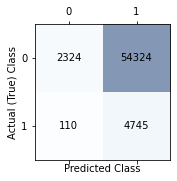

In [123]:
### Naive Bayes
from sklearn.naive_bayes import GaussianNB
gnb=GaussianNB().fit(trainX_std,y_train)
predictY=gnb.predict(testX_std)
CFmat=confusion_matrix(y_true=y_valid,y_pred=predictY)

fig,ax=plt.subplots(figsize=(2.5,2.5))
ax.matshow(CFmat,cmap=plt.cm.Blues,alpha=0.5)
for i in range(CFmat.shape[0]):
    for j in range(CFmat.shape[1]):
        ax.text(x=j,y=i,s=CFmat[i,j],va="center",ha="center")
plt.xlabel("Predicted Class")
plt.ylabel("Actual (True) Class")
plt.show

In [ ]:
### SVM(Nonlinear)
from sklearn.svm import SVC
ksvc=SVC(kernel='rbf',C=1).fit(trainX_std,y_train)
predictY=ksvc.predict(testX_std)
CFmat=confusion_matrix(y_true=y_valid,y_pred=predictY)

fig,ax=plt.subplots(figsize=(2.5,2.5))
ax.matshow(CFmat,cmap=plt.cm.Blues,alpha=0.5)
for i in range(CFmat.shape[0]):
    for j in range(CFmat.shape[1]):
        ax.text(x=j,y=i,s=CFmat[i,j],va="center",ha="center")
plt.xlabel("Predicted Class")
plt.ylabel("Actual (True) Class")
plt.show

In [ ]:
### Decision Tree
from sklearn.tree import DecisionTreeClassifier
dtree=DecisionTreeClassifier().fit(trainX_std,y_train)
predictY=dtree.predict(testX_std)
CFmat=confusion_matrix(y_true=y_valid,y_pred=predictY)

fig,ax=plt.subplots(figsize=(2.5,2.5))
ax.matshow(CFmat,cmap=plt.cm.Blues,alpha=0.5)
for i in range(CFmat.shape[0]):
    for j in range(CFmat.shape[1]):
        ax.text(x=j,y=i,s=CFmat[i,j],va="center",ha="center")
plt.xlabel("Predicted Class")
plt.ylabel("Actual (True) Class")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

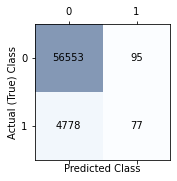

In [114]:
### LogisticRegression
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression(solver='liblinear').fit(trainX_std,y_train)
predictY=lr.predict(testX_std)
CFmat=confusion_matrix(y_true=y_valid,y_pred=predictY)

fig,ax=plt.subplots(figsize=(2.5,2.5))
ax.matshow(CFmat,cmap=plt.cm.Blues,alpha=0.5)
for i in range(CFmat.shape[0]):
    for j in range(CFmat.shape[1]):
        ax.text(x=j,y=i,s=CFmat[i,j],va="center",ha="center")
plt.xlabel("Predicted Class")
plt.ylabel("Actual (True) Class")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

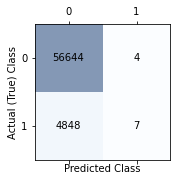

In [115]:
### Random Forest
from sklearn.ensemble import RandomForestClassifier
rforest=RandomForestClassifier().fit(trainX_std,y_train)
predictY=rforest.predict(testX_std)
CFmat=confusion_matrix(y_true=y_valid,y_pred=predictY)

fig,ax=plt.subplots(figsize=(2.5,2.5))
ax.matshow(CFmat,cmap=plt.cm.Blues,alpha=0.5)
for i in range(CFmat.shape[0]):
    for j in range(CFmat.shape[1]):
        ax.text(x=j,y=i,s=CFmat[i,j],va="center",ha="center")
plt.xlabel("Predicted Class")
plt.ylabel("Actual (True) Class")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

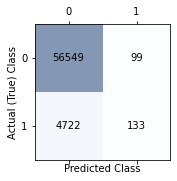

In [59]:
from lightgbm import LGBMClassifier


clf = LGBMClassifier().fit(trainX_std,y_train)
predictY = clf.predict(testX_std)
CFmat=confusion_matrix(y_true=y_valid,y_pred=predictY)

fig,ax=plt.subplots(figsize=(2.5,2.5))
ax.matshow(CFmat,cmap=plt.cm.Blues,alpha=0.5)
for i in range(CFmat.shape[0]):
    for j in range(CFmat.shape[1]):
        ax.text(x=j,y=i,s=CFmat[i,j],va="center",ha="center")
plt.xlabel("Predicted Class")
plt.ylabel("Actual (True) Class")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

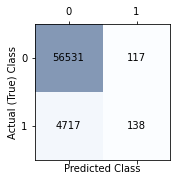

In [116]:
# test
from lightgbm import LGBMClassifier


clf = LGBMClassifier().fit(trainX_std,y_train)
predictY = clf.predict(testX_std)
CFmat=confusion_matrix(y_true=y_valid,y_pred=predictY)

fig,ax=plt.subplots(figsize=(2.5,2.5))
ax.matshow(CFmat,cmap=plt.cm.Blues,alpha=0.5)
for i in range(CFmat.shape[0]):
    for j in range(CFmat.shape[1]):
        ax.text(x=j,y=i,s=CFmat[i,j],va="center",ha="center")
plt.xlabel("Predicted Class")
plt.ylabel("Actual (True) Class")
plt.show

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


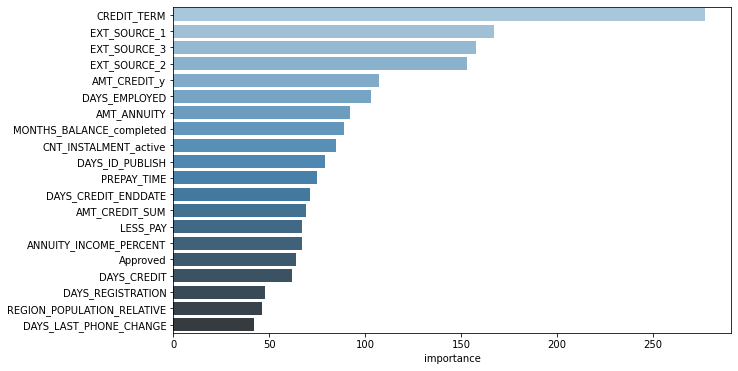

In [117]:
imp = pd.DataFrame(clf.feature_importances_,index=features,columns=['importance']).sort_values(by = 'importance',ascending=False).head(20)
plt.figure(figsize=(10,6))
sns.barplot(imp.importance,imp.index,orient = 'h',palette="Blues_d")
plt.show()

In [68]:
trainX_std[:,first]

array([[ 0.96944115, -0.30270105, -0.15998364, ..., -1.2334898 ,
         0.01163522, -1.96931659],
       [-1.6510881 , -0.87603451, -0.15998364, ..., -0.29757628,
         0.26557747,  1.44821535],
       [ 0.99831641, -0.76403593, -0.15998364, ...,  0.01439489,
         0.01163522,  0.63291717],
       ...,
       [-1.1988136 , -0.93963482, -0.15998364, ...,  1.15828919,
        -1.01950436,  0.11212232],
       [-0.65266338, -0.65327833, -0.15998364, ...,  0.01439489,
         0.01163522,  1.70630073],
       [ 0.86593948, -0.27508921, -0.15998364, ..., -0.40156667,
         0.01163522,  0.11212232]])

In [80]:
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout
y_valid_ =y_valid.values
y_train_ =y_train.values
y_valid_ = np.asarray(y_valid_).astype(np.float32)
y_train_ = np.asarray(y_train_).astype(np.float32)
X_train_=X_train.values
X_valid_=X_valid.values
# reshape input to be 3D [samples, timesteps, features]
X_train_ = X_train_.reshape((X_train_.shape[0], 1, X_train_.shape[1]))
X_valid_ = X_valid_.reshape((X_valid_.shape[0], 1, X_valid_.shape[1]))
print(X_train_.shape, y_train_.shape)
print(X_valid_.shape, y_valid_.shape)

(246008, 1, 224) (246008,)
(61503, 1, 224) (61503,)


In [81]:
model = Sequential()
model.add(LSTM(64,activation='relu', return_sequences=True, input_shape=(X_train_.shape[1], X_train_.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 64)             73984     
_________________________________________________________________
dropout (Dropout)            (None, 1, 64)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                23000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 97,035
Trainable params: 97,035
Non-trainable params: 0
_________________________________________________________________


In [84]:
pred = model.fit(X_train_, y_train_, batch_size=64, validation_split = 0.2, epochs=40, shuffle=False, verbose=1)

Epoch 1/40
3076/3076 [==============================] - 5s 2ms/step - loss: 0.2815 - accuracy: 0.9190 - val_loss: 1.5378 - val_accuracy: 0.9183
Epoch 2/40
3076/3076 [==============================] - 5s 2ms/step - loss: 0.2894 - accuracy: 0.9190 - val_loss: 1.7017 - val_accuracy: 0.9183
Epoch 3/40
3076/3076 [==============================] - 5s 2ms/step - loss: 0.3044 - accuracy: 0.9189 - val_loss: 1.2091 - val_accuracy: 0.9183
Epoch 4/40
3076/3076 [==============================] - 5s 2ms/step - loss: 0.2859 - accuracy: 0.9190 - val_loss: 1.3561 - val_accuracy: 0.9183
Epoch 5/40
3076/3076 [==============================] - 5s 2ms/step - loss: 0.2816 - accuracy: 0.9190 - val_loss: 1.3561 - val_accuracy: 0.9183
Epoch 6/40
3076/3076 [==============================] - 5s 2ms/step - loss: 0.2813 - accuracy: 0.9190 - val_loss: 1.3561 - val_accuracy: 0.9183
Epoch 7/40
3076/3076 [==============================] - 5s 2ms/step - loss: 0.2813 - accuracy: 0.9190 - val_loss: 1.3561 - val_accuracy:

In [85]:
res = model.predict(X_valid_)

In [91]:
res.min()

0.08022311

In [56]:
predict_X = test[features]
predict_X.fillna(X.median(),inplace=True)
predX_std=ss.transform(predict_X)
predictY=lr.predict_proba(predX_std)
submission = test['SK_ID_CURR'].to_frame()
submission['TARGET'] = predictY[:,1]
submission.to_csv('./working/submission_lr_2.csv',index=False)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [119]:
predict_X = test[features]
predict_X.fillna(X.median(),inplace=True)
predX_std=ss.transform(predict_X)
predictY=clf.predict_proba(predX_std)
submission = test['SK_ID_CURR'].to_frame()
submission['TARGET'] = predictY[:,1]
submission.to_csv('./working/submission_lgbm.csv',index=False)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [60]:
predictY=clf.predict_proba(predX_std)
submission = test['SK_ID_CURR'].to_frame()
submission['TARGET'] = predictY[:,1]
submission.to_csv('./working/submission_rf.csv',index=False)

LGBM: ROC AUC=0.774


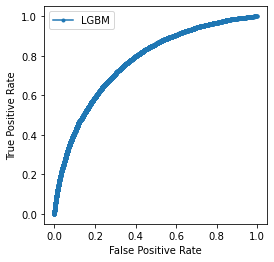

In [121]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

pre_probs1 = clf.predict_proba(testX_std)

pre_probs1 = pre_probs1[:, 1]

pre_auc = roc_auc_score(y_valid, pre_probs1)

print('LGBM: ROC AUC=%.3f' % (pre_auc))

pre_fpr, pre_tpr, _ = roc_curve(y_valid, pre_probs1)

plt.figure(figsize=(4,4))
plt.plot(pre_fpr, pre_tpr, marker='.', label='LGBM')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [51]:
pd.DataFrame(rforest.feature_importances_,index=features,columns=['importance']).sort_values(by='importance',ascending=False).head(20)

,importance
EXT_SOURCE_2,0.039189
EXT_SOURCE_3,0.032507
DAYS_BIRTH,0.022378
DAYS_ID_PUBLISH,0.021886
AMT_CREDIT_y,0.021376
PREPAY_TIME,0.021070
DAYS_EMPLOYED_PERCENT,0.020885
DAYS_REGISTRATION,0.020847
SK_ID_CURR,0.020350
CREDIT_TERM,0.020151
